In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

Enter the district name for analysis: Hiriyur
Average rainfall for Hiriyur: 43.974999999999994
Groundwater Trend for Hiriyur:
Pre-monsoon     4.6725
Monsoon         0.0000
Post-monsoon    2.3200
dtype: float64


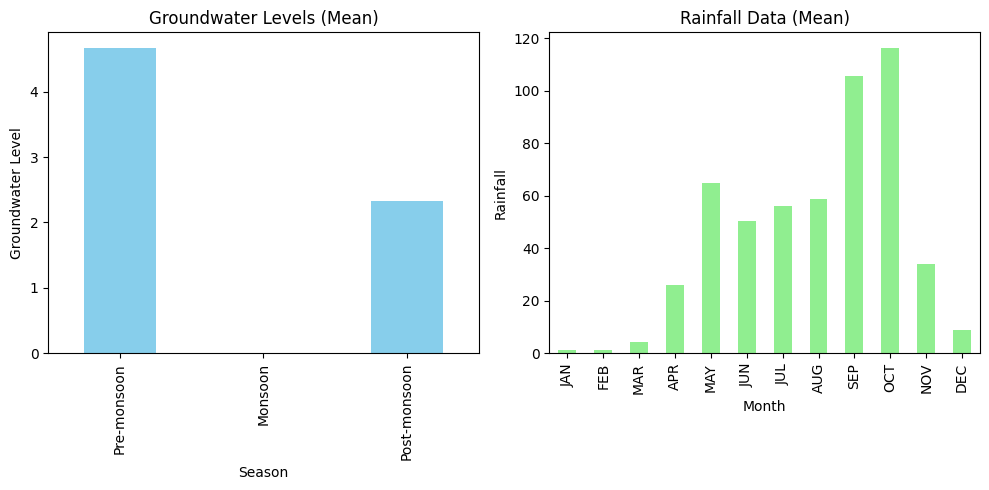

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Prediction Metrics:
MAE: 1.896217002868652, MSE: 3.5956389219681735, RMSE: 1.896217002868652, MedAE: 1.896217002868652, EVS: 1.0, NSE: nan
Water Conservation techniques is highly recommended due to acute shortage of groundwater levels and insufficient rainfall.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/modified_file2.csv'
data = pd.read_csv(file_path)

# User input for location
def get_groundwater_trend(location, location_column='Village'):
    filtered_data = data[data[location_column].str.contains(location, case=False, na=False)]
    if filtered_data.empty:
        raise ValueError(f"No data found for the location: {location}")

    # Extract groundwater and rainfall data
    groundwater_cols = [col for col in data.columns if 'monsoon' in col]
    rainfall_cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

    # Aggregate groundwater data
    groundwater_data = pd.Series({
        'Pre-monsoon': filtered_data[[col for col in groundwater_cols if 'Pre' in col]].mean(axis=1).mean(),
        'Monsoon': filtered_data[[col for col in groundwater_cols if 'Monsoon' in col]].mean(axis=1).mean(),
        'Post-monsoon': filtered_data[[col for col in groundwater_cols if 'Post' in col]].mean(axis=1).mean()
    })

    # Handle NaN values
    groundwater_data.fillna(0, inplace=True)  # Replace NaN with 0 or use groundwater_data.mean() for averaging

    # Aggregate rainfall data
    rainfall_data = filtered_data[rainfall_cols].mean()
    rainfall_aggregated = pd.Series({
        'Pre-monsoon': rainfall_data[['JAN', 'FEB', 'MAR', 'APR', 'MAY']].mean(),
        'Monsoon': rainfall_data[['JUN', 'JUL', 'AUG', 'SEP']].mean(),
        'Post-monsoon': rainfall_data[['OCT', 'NOV', 'DEC']].mean()
    })

    average_rainfall = rainfall_data.mean()
    print(f"Average rainfall for {location}: {average_rainfall}")

    print(f"Groundwater Trend for {location}:")
    print(groundwater_data)

    # Plotting
    plt.figure(figsize=(10, 5))

    # Plot groundwater levels
    plt.subplot(1, 2, 1)
    groundwater_data.plot(kind='bar', color='skyblue', title='Groundwater Levels (Mean)', xlabel='Season', ylabel='Groundwater Level')

    # Plot rainfall data
    plt.subplot(1, 2, 2)
    rainfall_data.plot(kind='bar', color='lightgreen', title='Rainfall Data (Mean)', xlabel='Month', ylabel='Rainfall')

    plt.tight_layout()
    plt.show()

    return groundwater_data, rainfall_aggregated, average_rainfall

# Prediction function
def predict_rainwater_harvesting(groundwater_data, rainfall_data, average_rainfall):
    # Prepare input dataset
    X = np.column_stack((rainfall_data.values, [average_rainfall] * len(rainfall_data)))  # Add average rainfall as a feature
    y = groundwater_data.values

    # Ensure consistent lengths
    if len(X) != len(y):
        raise ValueError(f"Mismatch in lengths: Rainfall data has {len(X)} samples, Groundwater data has {len(y)} samples.")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build neural network model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(loss=Huber(), optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)

    # Predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    medae = median_absolute_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)


    # Define NSE metric
    def nse(y_true, y_pred):
        numerator = np.sum((y_true - y_pred.flatten()) ** 2)
        denominator = np.sum((y_true - np.mean(y_true)) ** 2)
        if denominator == 0:
            return np.nan  # Variance is zero; cannot calculate NSE
        return 1 - numerator / denominator

    nse_score = nse(y_test, y_pred)

    print("\nPrediction Metrics:")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MedAE: {medae}, EVS: {evs}, NSE: {nse_score}")

    # Suggest rainwater harvesting based on thresholds
    # Combine the criteria: groundwater levels and rainfall
    threshold_groundwater = 20  # Example threshold for groundwater levels
    threshold_rainfall = 200  # Example threshold for average rainfall (mm)

    if groundwater_data.mean() < threshold_groundwater and average_rainfall < threshold_rainfall:
        print("Water Conservation techniques is highly recommended due to acute shortage of groundwater levels and insufficient rainfall.")
    elif groundwater_data.mean() < threshold_groundwater:
        print("RWater Conservation techniques is recommended due to low groundwater levels.")
    elif average_rainfall < threshold_rainfall:
        print("Water Conservation techniques is recommended due to insufficient rainfall.")
    else:
        print("Water Conservation techniques is not immediately necessary.")

# Example usage
location = input("Enter the district name for analysis: ")  # Allows the user to input location dynamically

try:
    # Fetch groundwater and rainfall data for the given location
    groundwater_data, rainfall_data, average_rainfall = get_groundwater_trend(location)
    # Predict rainwater harvesting needs
    predict_rainwater_harvesting(groundwater_data, rainfall_data, average_rainfall)
except ValueError as e:
    print(e)
